In [1]:
import numpy as np
import random
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import opacus
from opacus.validators import ModuleValidator
from opacus import PrivacyEngine
from opacus.utils.batch_memory_manager import BatchMemoryManager

SEED = 1024
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

#### simulate points

In [2]:
# multivariate gaussian
f_0 = np.random.multivariate_normal(  # majority of class 0
    mean=[5, 5], cov=[[3, 0], [0, 3]], size=1000
)  
f_1 = np.random.multivariate_normal(  # majority of class 1
    mean=[13, 5], cov=[[3, 0], [0, 3]], size=1000
)
# point mass gaussian
f_0_1 = np.random.multivariate_normal(  # minority of class 1
    mean=[-3, 10], cov=[[1, 0], [0, 1]], size=50
)
f_1_1 = np.random.multivariate_normal(  # minority of class 0
    mean=[23, 0], cov=[[1, 0], [0, 1]], size=50
)

In [3]:
f_0.shape, f_0_1.shape

((1000, 2), (50, 2))

In [4]:
x1_0, x2_0 = np.concatenate([f_0[:, 0], f_1_1[:, 0]]), np.concatenate([f_0[:, 1], f_1_1[:, 1]])  # class 0
x1_1, x2_1 = np.concatenate([f_1[:, 0], f_0_1[:, 0]]), np.concatenate([f_1[:, 1], f_0_1[:, 1]])  # class 1

In [5]:
x1_0.shape, x2_0.shape, x1_1.shape, x2_1.shape

((1050,), (1050,), (1050,), (1050,))

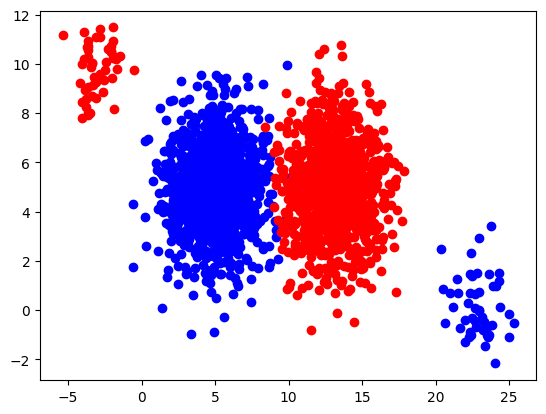

In [6]:
plt.scatter(x1_0, x2_0, color='blue')
plt.scatter(x1_1, x2_1, color='red')
plt.show()

#### create dataset

In [7]:
all_x1 = np.concatenate([x1_0, x1_1])
all_x2 = np.concatenate([x2_0, x2_1])
all_y = np.concatenate([np.zeros(len(x1_0)), np.ones(len(x1_1))]).astype(int)

In [8]:
len(all_x1), len(all_x2), len(all_y)

(2100, 2100, 2100)

In [9]:
dat = pd.DataFrame({'x1': all_x1, 'x2': all_x2, 'y': all_y})

In [10]:
dat.head()

,x1,x2,y
0,8.679653,5.437596,0
1,7.518711,5.985952,0
2,5.793667,3.598193,0
3,6.496619,5.349357,0
4,1.751887,4.015317,0


In [11]:
x_data = torch.tensor(dat[['x1', 'x2']].values, dtype=torch.float32)
y_data = torch.tensor(dat[['y']].values, dtype=torch.long)

In [12]:
x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, random_state=SEED, test_size=0.2, shuffle=True)

#### model

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
N_DIM = 2
N_CLASS = 2

# class MLP(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.linear1 = nn.Linear(N_DIM, 32)
#         self.linear2 = nn.Linear(32, 64)
#         self.linear3 = nn.Linear(64, 32)
#         self.linear4 = nn.Linear(32, N_CLASS)
#         self.relu = nn.ReLU()
#         # self.dropout = nn.Dropout(p=0.25)
#     def forward(self, x):
#         return self.linear4(self.relu(self.linear3(self.relu(self.linear2(self.relu(self.linear1(x)))))))
# model = MLP().to(device)

model = nn.Sequential(
    nn.Linear(N_DIM, 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, N_CLASS)
)
model = model.to(device)

In [15]:
model

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=64, bias=True)
  (7): ReLU()
  (8): Linear(in_features=64, out_features=32, bias=True)
  (9): ReLU()
  (10): Linear(in_features=32, out_features=2, bias=True)
)

In [16]:
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=LR)

#### non-priv train

In [17]:
def np_to_torch(x):
    return torch.from_numpy(x).to(torch.float32).to(device)

def torch_to_np(x):
    return x.cpu().detach().numpy()

In [18]:
def accuracy(preds, labels):
    return (torch_to_np(preds) == torch_to_np(labels)).mean()

In [19]:
EPOCHS = 10000
EVAL_EVERY = 100

x_train, x_valid = x_train.to(device), x_valid.to(device)
y_train, y_valid = y_train.to(device), y_valid.to(device)

step_counter = 0
train_loss_values, valid_loss_values = [], []

for epoch in tqdm(range(EPOCHS + 1)):

    model.train()

    y_logits = model(x_train)
    loss = loss_fn(y_logits, y_train.flatten())
    _, y_pred = torch.max(y_logits, 1)
    acc = accuracy(y_pred, y_train.flatten())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    step_counter += 1
    
    if step_counter % EVAL_EVERY == 0:    
        model.eval()
        with torch.inference_mode():
            valid_logits = model(x_valid)
            valid_loss = loss_fn(valid_logits, y_valid.flatten())
            _, valid_pred = torch.max(valid_logits, 1)
            valid_acc = accuracy(valid_pred, y_valid.flatten())
            
        print(f'Epoch: {epoch:4.0f} | Step: {step_counter:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')
        train_loss_values.append(loss.detach().cpu().numpy())
        valid_loss_values.append(valid_loss.detach().cpu().numpy())

  3%|█                                     | 269/10001 [00:00<00:10, 969.68it/s]

Epoch:   99 | Step:  100 | Train Loss: 0.69651, Accuracy: 0.50% | Validation Loss: 0.69488, Accuracy: 0.51%
Epoch:  199 | Step:  200 | Train Loss: 0.69123, Accuracy: 0.50% | Validation Loss: 0.69018, Accuracy: 0.51%
Epoch:  299 | Step:  300 | Train Loss: 0.68709, Accuracy: 0.50% | Validation Loss: 0.68651, Accuracy: 0.51%


  6%|██▏                                  | 602/10001 [00:00<00:08, 1069.70it/s]

Epoch:  399 | Step:  400 | Train Loss: 0.68357, Accuracy: 0.91% | Validation Loss: 0.68337, Accuracy: 0.91%
Epoch:  499 | Step:  500 | Train Loss: 0.67989, Accuracy: 0.88% | Validation Loss: 0.68003, Accuracy: 0.88%
Epoch:  599 | Step:  600 | Train Loss: 0.67500, Accuracy: 0.80% | Validation Loss: 0.67550, Accuracy: 0.81%


  8%|███                                  | 822/10001 [00:00<00:08, 1083.60it/s]

Epoch:  699 | Step:  700 | Train Loss: 0.67023, Accuracy: 0.75% | Validation Loss: 0.67110, Accuracy: 0.74%
Epoch:  799 | Step:  800 | Train Loss: 0.66618, Accuracy: 0.70% | Validation Loss: 0.66730, Accuracy: 0.70%
Epoch:  899 | Step:  900 | Train Loss: 0.66201, Accuracy: 0.67% | Validation Loss: 0.66339, Accuracy: 0.66%


 12%|████▏                               | 1158/10001 [00:01<00:07, 1106.46it/s]

Epoch:  999 | Step: 1000 | Train Loss: 0.65745, Accuracy: 0.65% | Validation Loss: 0.65908, Accuracy: 0.63%
Epoch: 1099 | Step: 1100 | Train Loss: 0.65239, Accuracy: 0.64% | Validation Loss: 0.65430, Accuracy: 0.61%
Epoch: 1199 | Step: 1200 | Train Loss: 0.64677, Accuracy: 0.62% | Validation Loss: 0.64897, Accuracy: 0.60%


 15%|█████▎                              | 1492/10001 [00:01<00:07, 1108.47it/s]

Epoch: 1299 | Step: 1300 | Train Loss: 0.64050, Accuracy: 0.62% | Validation Loss: 0.64301, Accuracy: 0.60%
Epoch: 1399 | Step: 1400 | Train Loss: 0.63352, Accuracy: 0.63% | Validation Loss: 0.63631, Accuracy: 0.60%
Epoch: 1499 | Step: 1500 | Train Loss: 0.62565, Accuracy: 0.64% | Validation Loss: 0.62866, Accuracy: 0.62%


 17%|██████▏                             | 1715/10001 [00:01<00:07, 1108.09it/s]

Epoch: 1599 | Step: 1600 | Train Loss: 0.61739, Accuracy: 0.65% | Validation Loss: 0.62062, Accuracy: 0.63%
Epoch: 1699 | Step: 1700 | Train Loss: 0.60879, Accuracy: 0.66% | Validation Loss: 0.61216, Accuracy: 0.65%
Epoch: 1799 | Step: 1800 | Train Loss: 0.59964, Accuracy: 0.68% | Validation Loss: 0.60305, Accuracy: 0.67%


 21%|███████▍                            | 2051/10001 [00:01<00:07, 1108.16it/s]

Epoch: 1899 | Step: 1900 | Train Loss: 0.58994, Accuracy: 0.70% | Validation Loss: 0.59326, Accuracy: 0.70%
Epoch: 1999 | Step: 2000 | Train Loss: 0.58005, Accuracy: 0.72% | Validation Loss: 0.58317, Accuracy: 0.73%
Epoch: 2099 | Step: 2100 | Train Loss: 0.56997, Accuracy: 0.74% | Validation Loss: 0.57275, Accuracy: 0.75%


 24%|████████▌                           | 2386/10001 [00:02<00:06, 1109.18it/s]

Epoch: 2199 | Step: 2200 | Train Loss: 0.55957, Accuracy: 0.76% | Validation Loss: 0.56188, Accuracy: 0.76%
Epoch: 2299 | Step: 2300 | Train Loss: 0.54880, Accuracy: 0.78% | Validation Loss: 0.55060, Accuracy: 0.77%
Epoch: 2399 | Step: 2400 | Train Loss: 0.53807, Accuracy: 0.79% | Validation Loss: 0.53933, Accuracy: 0.80%


 27%|█████████▊                          | 2722/10001 [00:02<00:06, 1112.03it/s]

Epoch: 2499 | Step: 2500 | Train Loss: 0.52756, Accuracy: 0.80% | Validation Loss: 0.52832, Accuracy: 0.81%
Epoch: 2599 | Step: 2600 | Train Loss: 0.51729, Accuracy: 0.81% | Validation Loss: 0.51764, Accuracy: 0.82%
Epoch: 2699 | Step: 2700 | Train Loss: 0.50735, Accuracy: 0.81% | Validation Loss: 0.50731, Accuracy: 0.83%


 29%|██████████▌                         | 2946/10001 [00:02<00:06, 1111.42it/s]

Epoch: 2799 | Step: 2800 | Train Loss: 0.49768, Accuracy: 0.83% | Validation Loss: 0.49722, Accuracy: 0.84%
Epoch: 2899 | Step: 2900 | Train Loss: 0.48830, Accuracy: 0.84% | Validation Loss: 0.48737, Accuracy: 0.85%
Epoch: 2999 | Step: 3000 | Train Loss: 0.47915, Accuracy: 0.84% | Validation Loss: 0.47778, Accuracy: 0.86%


 33%|███████████▊                        | 3284/10001 [00:03<00:06, 1116.14it/s]

Epoch: 3099 | Step: 3100 | Train Loss: 0.47026, Accuracy: 0.85% | Validation Loss: 0.46848, Accuracy: 0.86%
Epoch: 3199 | Step: 3200 | Train Loss: 0.46162, Accuracy: 0.86% | Validation Loss: 0.45948, Accuracy: 0.86%
Epoch: 3299 | Step: 3300 | Train Loss: 0.45321, Accuracy: 0.87% | Validation Loss: 0.45075, Accuracy: 0.87%


 36%|█████████████                       | 3621/10001 [00:03<00:05, 1116.91it/s]

Epoch: 3399 | Step: 3400 | Train Loss: 0.44500, Accuracy: 0.88% | Validation Loss: 0.44229, Accuracy: 0.87%
Epoch: 3499 | Step: 3500 | Train Loss: 0.43697, Accuracy: 0.88% | Validation Loss: 0.43408, Accuracy: 0.88%
Epoch: 3599 | Step: 3600 | Train Loss: 0.42910, Accuracy: 0.88% | Validation Loss: 0.42613, Accuracy: 0.88%


 38%|█████████████▊                      | 3845/10001 [00:03<00:05, 1112.88it/s]

Epoch: 3699 | Step: 3700 | Train Loss: 0.42133, Accuracy: 0.88% | Validation Loss: 0.41833, Accuracy: 0.88%
Epoch: 3799 | Step: 3800 | Train Loss: 0.41371, Accuracy: 0.89% | Validation Loss: 0.41075, Accuracy: 0.88%
Epoch: 3899 | Step: 3900 | Train Loss: 0.40635, Accuracy: 0.89% | Validation Loss: 0.40346, Accuracy: 0.89%


 42%|███████████████                     | 4181/10001 [00:03<00:05, 1113.96it/s]

Epoch: 3999 | Step: 4000 | Train Loss: 0.39925, Accuracy: 0.89% | Validation Loss: 0.39649, Accuracy: 0.89%
Epoch: 4099 | Step: 4100 | Train Loss: 0.39231, Accuracy: 0.89% | Validation Loss: 0.38972, Accuracy: 0.89%
Epoch: 4199 | Step: 4200 | Train Loss: 0.38551, Accuracy: 0.89% | Validation Loss: 0.38311, Accuracy: 0.90%


 45%|████████████████▎                   | 4518/10001 [00:04<00:04, 1115.13it/s]

Epoch: 4299 | Step: 4300 | Train Loss: 0.37884, Accuracy: 0.89% | Validation Loss: 0.37666, Accuracy: 0.90%
Epoch: 4399 | Step: 4400 | Train Loss: 0.37229, Accuracy: 0.90% | Validation Loss: 0.37035, Accuracy: 0.90%
Epoch: 4499 | Step: 4500 | Train Loss: 0.36580, Accuracy: 0.90% | Validation Loss: 0.36416, Accuracy: 0.90%


 47%|█████████████████                   | 4742/10001 [00:04<00:04, 1116.14it/s]

Epoch: 4599 | Step: 4600 | Train Loss: 0.35931, Accuracy: 0.90% | Validation Loss: 0.35800, Accuracy: 0.90%
Epoch: 4699 | Step: 4700 | Train Loss: 0.35286, Accuracy: 0.90% | Validation Loss: 0.35185, Accuracy: 0.90%
Epoch: 4799 | Step: 4800 | Train Loss: 0.34646, Accuracy: 0.90% | Validation Loss: 0.34575, Accuracy: 0.90%


 51%|██████████████████▎                 | 5078/10001 [00:04<00:04, 1112.27it/s]

Epoch: 4899 | Step: 4900 | Train Loss: 0.34007, Accuracy: 0.90% | Validation Loss: 0.33959, Accuracy: 0.90%
Epoch: 4999 | Step: 5000 | Train Loss: 0.33364, Accuracy: 0.90% | Validation Loss: 0.33333, Accuracy: 0.90%
Epoch: 5099 | Step: 5100 | Train Loss: 0.32708, Accuracy: 0.90% | Validation Loss: 0.32693, Accuracy: 0.91%


 54%|███████████████████▍                | 5414/10001 [00:04<00:04, 1107.61it/s]

Epoch: 5199 | Step: 5200 | Train Loss: 0.32051, Accuracy: 0.90% | Validation Loss: 0.32048, Accuracy: 0.91%
Epoch: 5299 | Step: 5300 | Train Loss: 0.31391, Accuracy: 0.91% | Validation Loss: 0.31396, Accuracy: 0.91%
Epoch: 5399 | Step: 5400 | Train Loss: 0.30723, Accuracy: 0.91% | Validation Loss: 0.30732, Accuracy: 0.91%


 56%|████████████████████▎               | 5637/10001 [00:05<00:03, 1108.23it/s]

Epoch: 5499 | Step: 5500 | Train Loss: 0.30044, Accuracy: 0.91% | Validation Loss: 0.30054, Accuracy: 0.91%
Epoch: 5599 | Step: 5600 | Train Loss: 0.29323, Accuracy: 0.91% | Validation Loss: 0.29342, Accuracy: 0.91%
Epoch: 5699 | Step: 5700 | Train Loss: 0.28568, Accuracy: 0.91% | Validation Loss: 0.28580, Accuracy: 0.91%


 60%|█████████████████████▌              | 5973/10001 [00:05<00:03, 1112.27it/s]

Epoch: 5799 | Step: 5800 | Train Loss: 0.27823, Accuracy: 0.91% | Validation Loss: 0.27820, Accuracy: 0.91%
Epoch: 5899 | Step: 5900 | Train Loss: 0.27092, Accuracy: 0.91% | Validation Loss: 0.27069, Accuracy: 0.91%
Epoch: 5999 | Step: 6000 | Train Loss: 0.26377, Accuracy: 0.91% | Validation Loss: 0.26326, Accuracy: 0.91%


 63%|██████████████████████▋             | 6309/10001 [00:05<00:03, 1110.37it/s]

Epoch: 6099 | Step: 6100 | Train Loss: 0.25672, Accuracy: 0.91% | Validation Loss: 0.25585, Accuracy: 0.91%
Epoch: 6199 | Step: 6200 | Train Loss: 0.24982, Accuracy: 0.91% | Validation Loss: 0.24845, Accuracy: 0.91%
Epoch: 6299 | Step: 6300 | Train Loss: 0.24297, Accuracy: 0.91% | Validation Loss: 0.24102, Accuracy: 0.91%


 65%|███████████████████████▌            | 6534/10001 [00:05<00:03, 1112.35it/s]

Epoch: 6399 | Step: 6400 | Train Loss: 0.23622, Accuracy: 0.91% | Validation Loss: 0.23361, Accuracy: 0.91%
Epoch: 6499 | Step: 6500 | Train Loss: 0.22968, Accuracy: 0.92% | Validation Loss: 0.22632, Accuracy: 0.91%
Epoch: 6599 | Step: 6600 | Train Loss: 0.22341, Accuracy: 0.92% | Validation Loss: 0.21921, Accuracy: 0.91%


 69%|████████████████████████▋           | 6871/10001 [00:06<00:02, 1113.90it/s]

Epoch: 6699 | Step: 6700 | Train Loss: 0.21740, Accuracy: 0.92% | Validation Loss: 0.21230, Accuracy: 0.91%
Epoch: 6799 | Step: 6800 | Train Loss: 0.21167, Accuracy: 0.92% | Validation Loss: 0.20562, Accuracy: 0.92%
Epoch: 6899 | Step: 6900 | Train Loss: 0.20616, Accuracy: 0.92% | Validation Loss: 0.19914, Accuracy: 0.92%


 72%|█████████████████████████▉          | 7207/10001 [00:06<00:02, 1109.09it/s]

Epoch: 6999 | Step: 7000 | Train Loss: 0.20083, Accuracy: 0.92% | Validation Loss: 0.19286, Accuracy: 0.92%
Epoch: 7099 | Step: 7100 | Train Loss: 0.19570, Accuracy: 0.93% | Validation Loss: 0.18680, Accuracy: 0.92%
Epoch: 7199 | Step: 7200 | Train Loss: 0.19083, Accuracy: 0.93% | Validation Loss: 0.18100, Accuracy: 0.92%


 74%|██████████████████████████▋         | 7431/10001 [00:06<00:02, 1108.21it/s]

Epoch: 7299 | Step: 7300 | Train Loss: 0.18617, Accuracy: 0.93% | Validation Loss: 0.17543, Accuracy: 0.92%
Epoch: 7399 | Step: 7400 | Train Loss: 0.18168, Accuracy: 0.93% | Validation Loss: 0.17007, Accuracy: 0.92%
Epoch: 7499 | Step: 7500 | Train Loss: 0.17742, Accuracy: 0.94% | Validation Loss: 0.16502, Accuracy: 0.92%


 78%|███████████████████████████▉        | 7765/10001 [00:07<00:02, 1108.90it/s]

Epoch: 7599 | Step: 7600 | Train Loss: 0.17336, Accuracy: 0.94% | Validation Loss: 0.16020, Accuracy: 0.93%
Epoch: 7699 | Step: 7700 | Train Loss: 0.16946, Accuracy: 0.94% | Validation Loss: 0.15557, Accuracy: 0.94%
Epoch: 7799 | Step: 7800 | Train Loss: 0.16569, Accuracy: 0.94% | Validation Loss: 0.15115, Accuracy: 0.95%


 81%|█████████████████████████████▏      | 8100/10001 [00:07<00:01, 1110.04it/s]

Epoch: 7899 | Step: 7900 | Train Loss: 0.16207, Accuracy: 0.95% | Validation Loss: 0.14694, Accuracy: 0.96%
Epoch: 7999 | Step: 8000 | Train Loss: 0.15858, Accuracy: 0.95% | Validation Loss: 0.14292, Accuracy: 0.96%
Epoch: 8099 | Step: 8100 | Train Loss: 0.15523, Accuracy: 0.95% | Validation Loss: 0.13909, Accuracy: 0.96%


 83%|█████████████████████████████▉      | 8324/10001 [00:07<00:01, 1110.70it/s]

Epoch: 8199 | Step: 8200 | Train Loss: 0.15201, Accuracy: 0.95% | Validation Loss: 0.13546, Accuracy: 0.96%
Epoch: 8299 | Step: 8300 | Train Loss: 0.14892, Accuracy: 0.95% | Validation Loss: 0.13198, Accuracy: 0.96%
Epoch: 8399 | Step: 8400 | Train Loss: 0.14596, Accuracy: 0.96% | Validation Loss: 0.12866, Accuracy: 0.96%


 87%|███████████████████████████████▏    | 8659/10001 [00:07<00:01, 1109.36it/s]

Epoch: 8499 | Step: 8500 | Train Loss: 0.14312, Accuracy: 0.96% | Validation Loss: 0.12549, Accuracy: 0.96%
Epoch: 8599 | Step: 8600 | Train Loss: 0.14040, Accuracy: 0.96% | Validation Loss: 0.12247, Accuracy: 0.96%
Epoch: 8699 | Step: 8700 | Train Loss: 0.13780, Accuracy: 0.96% | Validation Loss: 0.11960, Accuracy: 0.96%


 90%|████████████████████████████████▍   | 8997/10001 [00:08<00:00, 1116.06it/s]

Epoch: 8799 | Step: 8800 | Train Loss: 0.13530, Accuracy: 0.96% | Validation Loss: 0.11686, Accuracy: 0.96%
Epoch: 8899 | Step: 8900 | Train Loss: 0.13288, Accuracy: 0.96% | Validation Loss: 0.11426, Accuracy: 0.96%
Epoch: 8999 | Step: 9000 | Train Loss: 0.13055, Accuracy: 0.96% | Validation Loss: 0.11177, Accuracy: 0.97%


 92%|█████████████████████████████████▏  | 9222/10001 [00:08<00:00, 1115.46it/s]

Epoch: 9099 | Step: 9100 | Train Loss: 0.12832, Accuracy: 0.96% | Validation Loss: 0.10937, Accuracy: 0.97%
Epoch: 9199 | Step: 9200 | Train Loss: 0.12617, Accuracy: 0.96% | Validation Loss: 0.10709, Accuracy: 0.97%
Epoch: 9299 | Step: 9300 | Train Loss: 0.12410, Accuracy: 0.96% | Validation Loss: 0.10492, Accuracy: 0.97%


 96%|██████████████████████████████████▍ | 9558/10001 [00:08<00:00, 1114.51it/s]

Epoch: 9399 | Step: 9400 | Train Loss: 0.12211, Accuracy: 0.96% | Validation Loss: 0.10286, Accuracy: 0.97%
Epoch: 9499 | Step: 9500 | Train Loss: 0.12018, Accuracy: 0.96% | Validation Loss: 0.10089, Accuracy: 0.97%
Epoch: 9599 | Step: 9600 | Train Loss: 0.11832, Accuracy: 0.96% | Validation Loss: 0.09899, Accuracy: 0.97%


 99%|███████████████████████████████████▌| 9895/10001 [00:08<00:00, 1116.82it/s]

Epoch: 9699 | Step: 9700 | Train Loss: 0.11652, Accuracy: 0.96% | Validation Loss: 0.09718, Accuracy: 0.97%
Epoch: 9799 | Step: 9800 | Train Loss: 0.11480, Accuracy: 0.96% | Validation Loss: 0.09545, Accuracy: 0.97%
Epoch: 9899 | Step: 9900 | Train Loss: 0.11314, Accuracy: 0.96% | Validation Loss: 0.09378, Accuracy: 0.97%


100%|███████████████████████████████████| 10001/10001 [00:09<00:00, 1104.11it/s]

Epoch: 9999 | Step: 10000 | Train Loss: 0.11154, Accuracy: 0.96% | Validation Loss: 0.09217, Accuracy: 0.97%


#### priv train

In [20]:
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
valid_dataset = TensorDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=len(valid_dataset))

In [21]:
MAX_GRAD_NORM = 1.0
EPSILON = 5.0
DELTA = 1e-5
# BATCH_SIZE = 512
# MAX_PHYSICAL_BATCH_SIZE = 128
MAX_PHYSICAL_BATCH_SIZE = len(train_dataset)
EPOCHS = 300

In [22]:
model_priv = ModuleValidator.fix(model)

/home/qiaoyuet/project/venvs/py310/lib/python3.10/site-packages/opacus/utils/module_utils.py:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  module_copy = torch.load(byte

In [23]:
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_priv.parameters(), lr=LR)

In [24]:
privacy_engine = PrivacyEngine()

model_priv, optimizer, train_loader = privacy_engine.make_private_with_epsilon(
    module=model_priv,
    optimizer=optimizer,
    data_loader=train_loader,
    epochs=EPOCHS,
    target_epsilon=EPSILON,
    target_delta=DELTA,
    max_grad_norm=MAX_GRAD_NORM,
)

print(f"Using sigma={optimizer.noise_multiplier} and C={MAX_GRAD_NORM}")

/home/qiaoyuet/project/venvs/py310/lib/python3.10/site-packages/opacus/privacy_engine.py:95: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/home/qiaoyuet/project/venvs/py310/lib/python3.10/site-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/home/qiaoyuet/project/venvs/py310/lib/python3.10/site-packages/opacus/accountants/analysis/prv/prvs.py:66: RuntimeWarning: divide by zero encountered in log
  z = np.log(np.where(t > np.log(1 - q), (np.exp(t) + q - 1) / q, 1))
/home/qiaoyuet/project/venvs/py310/lib/python3.10/site-packages/opacus/accountants/analysis/prv/prvs.py:69: RuntimeWarning: divide by zero encountered in log
  t > np.log(1 - q),


Using sigma=15.48828125 and C=1.0


In [25]:
step_counter = 0

for epoch in tqdm(range(EPOCHS + 1)):
    
    model_priv.train()

    with BatchMemoryManager(
        data_loader=train_loader, 
        max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE, 
        optimizer=optimizer
    ) as memory_safe_data_loader:
        
         for i, (x_train, y_train) in enumerate(memory_safe_data_loader): 
            x_train = x_train.to(device)
            y_train = y_train.to(device)
            
            y_logits = model_priv(x_train)
            loss = loss_fn(y_logits, y_train.flatten())
            _, y_pred = torch.max(y_logits, 1)
            acc = accuracy(y_pred, y_train.flatten())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            step_counter += 1
            
            if step_counter % EVAL_EVERY == 0:
                epsilon = privacy_engine.get_epsilon(DELTA)
                model_priv.eval()
                with torch.inference_mode():
                    for x_valid, y_valid in valid_loader:
                        x_valid = x_valid.to(device)
                        y_valid = y_valid.to(device) 
                        
                        valid_logits = model_priv(x_valid)
                        valid_loss = loss_fn(valid_logits, y_valid.flatten())
                        _, valid_pred = torch.max(valid_logits, 1)
                        valid_acc = accuracy(valid_pred, y_valid.flatten())

                print(f'Epoch: {epoch:4.0f} | Step: {step_counter:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}% | Eps: {epsilon:.2f}')

  0%|                                                   | 0/301 [00:00<?, ?it/s]/home/qiaoyuet/project/venvs/py310/lib/python3.10/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
 37%|██████████████▉                          | 110/301 [00:01<00:02, 82.90it/s]

Epoch:   99 | Step:  100 | Train Loss: 0.11711, Accuracy: 0.96% | Validation Loss: 0.09736, Accuracy: 0.96% | Eps: 2.67


 71%|█████████████████████████████            | 213/301 [00:02<00:01, 79.01it/s]

Epoch:  199 | Step:  200 | Train Loss: 0.12296, Accuracy: 0.96% | Validation Loss: 0.10275, Accuracy: 0.96% | Eps: 3.95


100%|█████████████████████████████████████████| 301/301 [00:03<00:00, 81.75it/s]

Epoch:  299 | Step:  300 | Train Loss: 0.12663, Accuracy: 0.96% | Validation Loss: 0.10619, Accuracy: 0.96% | Eps: 4.99


#### plot

In [26]:
def infer(xinfer, model):
    model.eval()
    with torch.no_grad():
        ylogits = model(xinfer)
        _, yinfer = torch.max(ylogits, 1)
    return yinfer

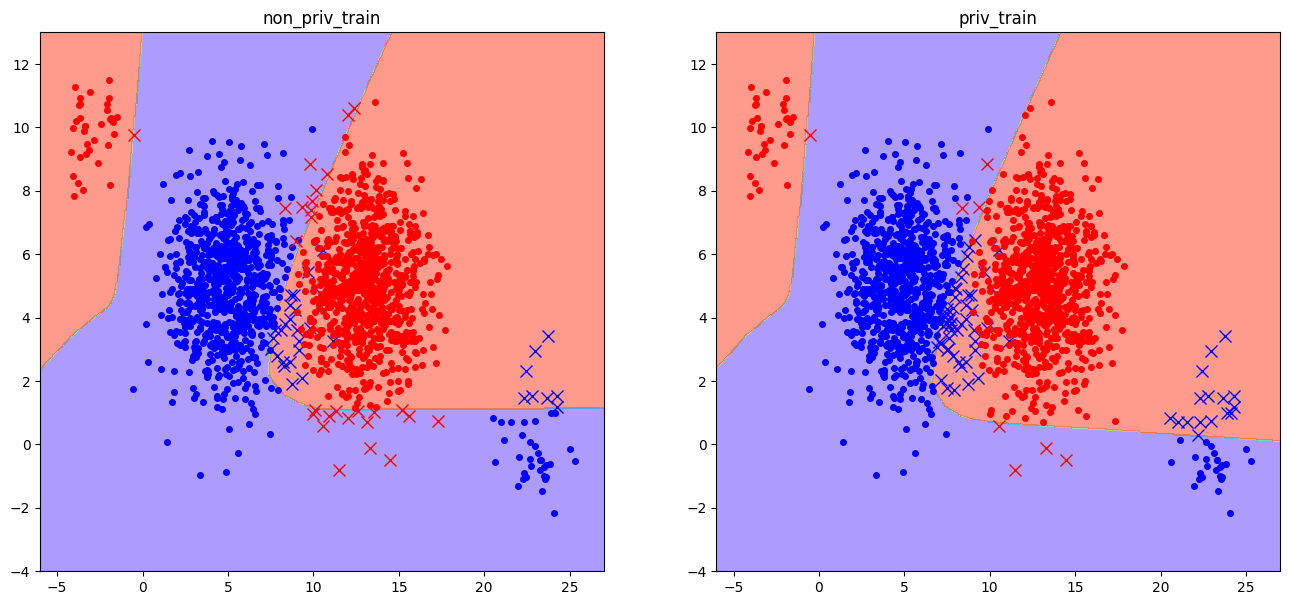

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

## non-priv model
xlin1 = np.linspace(round(torch_to_np(x_train[:, 0]).min()) - 2, round(torch_to_np(x_train[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_train[:, 1]).min()) - 2, round(torch_to_np(x_train[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax1.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 0]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 1]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax1.set_title('non_priv_train')
# ax1.legend(loc='lower left', framealpha=.5, fontsize=10)

## priv model
xlin1 = np.linspace(round(torch_to_np(x_train[:, 0]).min()) - 2, round(torch_to_np(x_train[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_train[:, 1]).min()) - 2, round(torch_to_np(x_train[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model_priv)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax2.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 0]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_train[y_train.ravel() == 1]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax2.set_title('priv_train')
# ax2.legend(loc='lower left', framealpha=.5, fontsize=10)

plt.show()
plt.close()

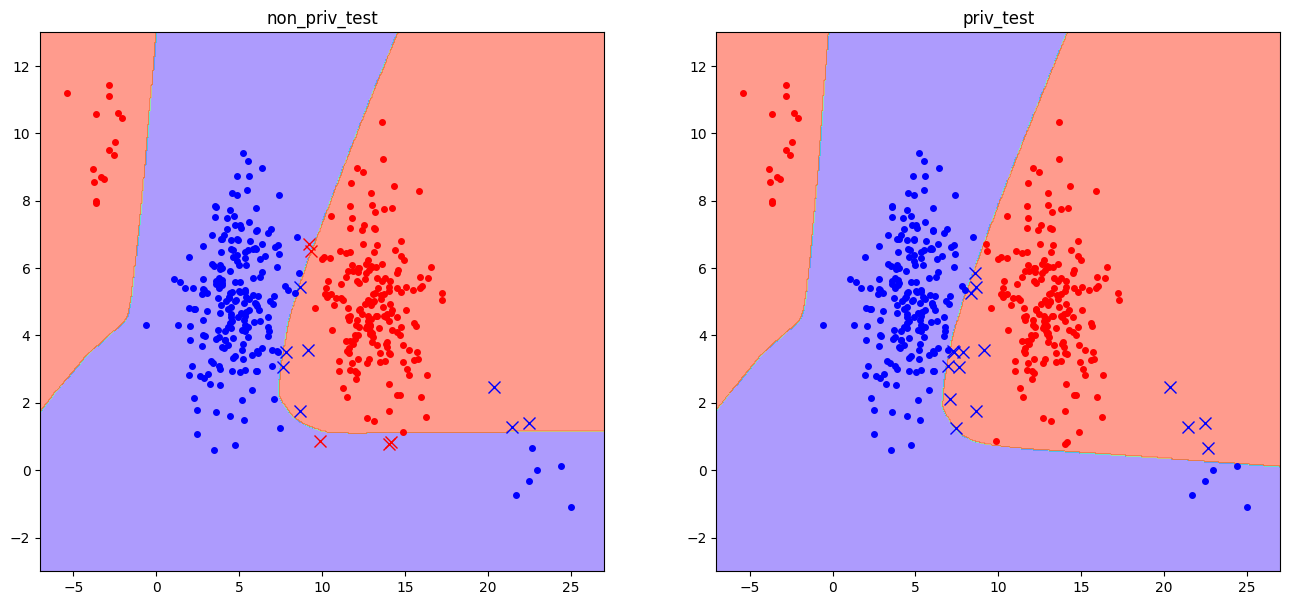

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

## non-priv model
xlin1 = np.linspace(round(torch_to_np(x_valid[:, 0]).min()) - 2, round(torch_to_np(x_valid[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_valid[:, 1]).min()) - 2, round(torch_to_np(x_valid[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax1.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 0]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 1]
yinfer = infer(xinfer, model)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax1.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax1.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax1.set_title('non_priv_test')
# ax1.legend(loc='lower left', framealpha=.5, fontsize=10)

## priv model
xlin1 = np.linspace(round(torch_to_np(x_valid[:, 0]).min()) - 2, round(torch_to_np(x_valid[:, 0]).max()) + 2, 500)
xlin2 = np.linspace(round(torch_to_np(x_valid[:, 1]).min()) - 2, round(torch_to_np(x_valid[:, 1]).max()) + 2, 500)
xx1, xx2 = np.meshgrid(xlin1, xlin2)
xinfer = np.column_stack([xx1.ravel(), xx2.ravel()])
xinfer = np_to_torch(xinfer)
yinfer = infer(xinfer, model_priv)
yinfer = torch_to_np(yinfer)
yy = np.reshape(yinfer, xx1.shape)

# make contour of decision boundary
ax2.contourf(xx1, xx2, yy, alpha=.5, cmap='rainbow')

# plot class 0
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 0]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], '.', 
         color='blue', markersize=8, label='class 0')
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], 'x', 
         color='blue', markersize=8, label='class 0 error')

# plot class 1
# correctly/wrongly predicted is plotted as point/cross
xinfer = x_valid[y_valid.ravel() == 1]
yinfer = infer(xinfer, model_priv)
xinfer = torch_to_np(xinfer)
yinfer = torch_to_np(yinfer)
ax2.plot(xinfer[yinfer.ravel() == 1, 0], xinfer[yinfer.ravel() == 1, 1], '.', 
         color='red', markersize=8, label='class 1')
ax2.plot(xinfer[yinfer.ravel() == 0, 0], xinfer[yinfer.ravel() == 0, 1], 'x', 
         color='red', markersize=8, label='class 1 error')

ax2.set_title('priv_test')
# ax2.legend(loc='lower left', framealpha=.5, fontsize=10)

plt.show()
plt.close()